# Import required libraries

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision

## Triplet loss

The Triplet Loss encourages the distance between an anchor and a positive example to be smaller than the distance between the anchor and a negative example by at least a margin \( \alpha \).

$$
\mathcal{L}(A, P, N) = \max\left( \|f(A) - f(P)\|_2^2 - \|f(A) - f(N)\|_2^2 + \alpha, \; 0 \right)
$$

Where:

- \( A \): Anchor
- \( P \): Positive (same class)
- \( N \): Negative (different class)
- \( f(\cdot) \): Embedding function (e.g., neural network output)
- \( \alpha \): Margin (a positive constant)


In [6]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Compute squared L2 distances
        pos_dist = F.pairwise_distance(anchor, positive, p=2)
        neg_dist = F.pairwise_distance(anchor, negative, p=2)

        # Triplet loss
        loss = F.relu(pos_dist - neg_dist + self.margin)
        return loss.mean()


In [7]:
# Dummy embeddings (batch_size=4, embedding_dim=128)
anchor = torch.randn(4, 128, requires_grad=True)
positive = torch.randn(4, 128, requires_grad=True)
negative = torch.randn(4, 128, requires_grad=True)

criterion = TripletLoss(margin=1.0)
loss = criterion(anchor, positive, negative)

print("Triplet loss:", loss.item())
loss.backward()


Triplet loss: 0.8353085517883301


## Quadruplet Losses

The Quadruplet Loss improves upon Triplet Loss by adding a second negative sample and an additional constraint to enhance embedding separation.

$$
\mathcal{L}(A, P, N_1, N_2) = \max\left( \|f(A) - f(P)\|_2^2 - \|f(A) - f(N_1)\|_2^2 + \alpha, \; 0 \right) + \max\left( \|f(P) - f(N_2)\|_2^2 - \|f(N_1) - f(N_2)\|_2^2 + \beta, \; 0 \right)
$$

Where:

- \( A \): Anchor
- \( P \): Positive (same class)
- \( N_1 \): First Negative
- \( N_2 \): Second Negative (different class and ideally farther apart)
- \( f(\cdot) \): Embedding function (e.g., a neural network)
- \( \alpha \), \( \beta \): Margin hyperparameters


In [8]:
class QuadrupletLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=0.5):
        super(QuadrupletLoss, self).__init__()
        self.alpha = alpha  # Margin for anchor-positive-negative
        self.beta = beta    # Margin for positive-second negative

    def forward(self, anchor, positive, negative1, negative2):
        # L2 pairwise distances
        d_ap = F.pairwise_distance(anchor, positive, p=2)
        d_an = F.pairwise_distance(anchor, negative1, p=2)
        d_pn2 = F.pairwise_distance(positive, negative2, p=2)
        d_n1n2 = F.pairwise_distance(negative1, negative2, p=2)

        # First triplet term
        loss1 = F.relu(d_ap - d_an + self.alpha)

        # Second additional term
        loss2 = F.relu(d_pn2 - d_n1n2 + self.beta)

        # Combine both
        return (loss1 + loss2).mean()


In [9]:
# Example tensors (batch_size=4, embedding_dim=128)
anchor = torch.randn(4, 128, requires_grad=True)
positive = torch.randn(4, 128, requires_grad=True)
negative1 = torch.randn(4, 128, requires_grad=True)
negative2 = torch.randn(4, 128, requires_grad=True)

# Loss instance
criterion = QuadrupletLoss(alpha=1.0, beta=0.5)
loss = criterion(anchor, positive, negative1, negative2)

print("Quadruplet loss:", loss.item())
loss.backward()


Quadruplet loss: 1.6817049980163574


## SphereFace

In [10]:
class SphereFaceLoss(nn.Module):
    def __init__(self, in_features, out_features, m=4, scale=30.0):
        super(SphereFaceLoss, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.m = m
        self.scale = scale
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, labels):
        # Normalize input and weights
        x_norm = F.normalize(input, dim=1)
        w_norm = F.normalize(self.weight, dim=1)
        cos_theta = F.linear(x_norm, w_norm)

        # Convert cosine to angle then multiply by m (angle margin)
        theta = torch.acos(torch.clamp(cos_theta, -1.0 + 1e-7, 1.0 - 1e-7))
        k = (self.m * theta / math.pi).floor()
        phi_theta = torch.cos(self.m * theta)

        # One-hot encoding for labels
        one_hot = torch.zeros_like(cos_theta)
        one_hot.scatter_(1, labels.view(-1, 1), 1.0)

        # Replace target class cosine with phi_theta
        output = cos_theta * (1 - one_hot) + phi_theta * one_hot
        output *= self.scale
        return output


In [11]:
class SimpleCNN(nn.Module):
    def __init__(self, embedding_dim=2):  # For 2D visualization
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(64, embedding_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [12]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
trainset = datasets.MNIST('../test', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)


100%|██████████| 9.91M/9.91M [00:03<00:00, 2.74MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 36.6kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 814kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.13MB/s]


In [13]:
model = SimpleCNN(embedding_dim=2).to(device)
criterion = SphereFaceLoss(in_features=2, out_features=10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


# Store embeddings for plotting
all_feats = []
all_labels = []

for epoch in range(5):
    model.train()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        features = model(images)
        logits = criterion(features, labels)
        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item():.8f}")

    # Save embeddings for plotting
    model.eval()
    with torch.no_grad():
        sample_data = next(iter(trainloader))
        imgs, lbls = sample_data[0].to(device), sample_data[1]
        feats = model(imgs).cpu()
        all_feats.append(feats)
        all_labels.append(lbls)


Epoch 1, Loss: 15.86230946


KeyboardInterrupt: 

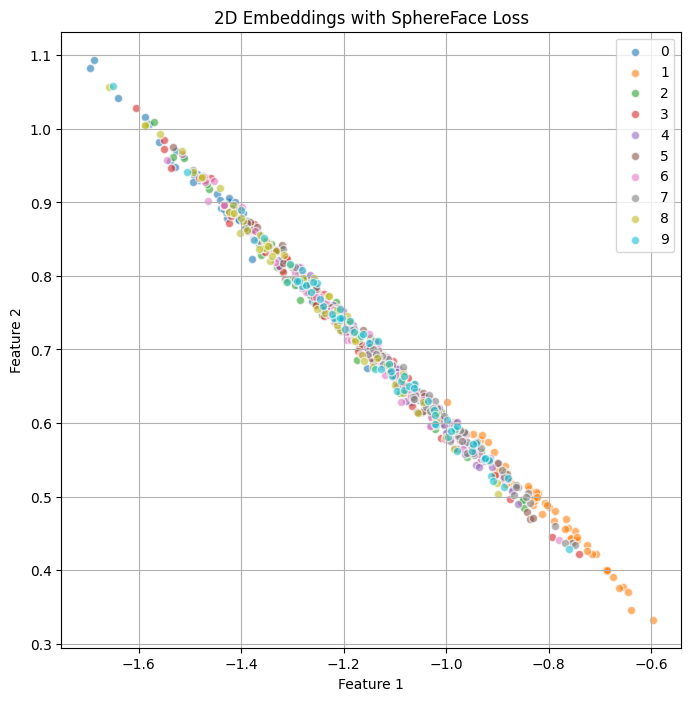

In [64]:
# Stack all embeddings
embeds = torch.cat(all_feats, dim=0)
labels = torch.cat(all_labels, dim=0)

plt.figure(figsize=(8, 8))
for i in range(10):
    idx = labels == i
    plt.scatter(embeds[idx, 0], embeds[idx, 1], label=str(i), alpha=0.6, edgecolors='w')

plt.legend()
plt.title("2D Embeddings with SphereFace Loss")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()


In [ ]:
from sklearn.manifold import TSNE
reduced = TSNE(n_components=2, random_state=42).fit_transform(embeds)
plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap="tab10", alpha=0.7)
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar()
plt.show()

## CosFace

The CosFace loss modifies the softmax function by introducing an additive margin to the cosine similarity:

**Formula:**

$$
\mathcal{L} = -\frac{1}{N} \sum_{i=1}^{N} \log \frac{e^{s (\cos(\theta_{y_i}) - m)}}{e^{s (\cos(\theta_{y_i}) - m)} + \sum_{j \ne y_i} e^{s \cos(\theta_j)}}
$$

Where:

- \( \theta_j \): angle between input and class \( j \)'s weight vector
- \( m \): additive cosine margin
- \( s \): scaling factor
- \( y_i \): ground truth class
- \( N \): batch size

This encourages greater separation between classes in angular space by enforcing a margin between the correct and incorrect logits.

---

In [30]:
class CosFaceLoss(nn.Module):
    def __init__(self, in_features, out_features, margin=0.35, scale=30.0):
        super(CosFaceLoss, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.margin = margin
        self.scale = scale
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, labels):
        # Normalize feature vectors and weights
        input_norm = F.normalize(input, dim=1)
        weight_norm = F.normalize(self.weight, dim=1)

        # Cosine similarity
        cosine = F.linear(input_norm, weight_norm)

        # Add margin to correct class
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1, 1), 1.0)

        output = cosine - one_hot * self.margin
        output *= self.scale
        return output


In [35]:
model = SimpleCNN(embedding_dim=128).to(device)
criterion = CosFaceLoss(in_features=128, out_features=10, margin=0.35, scale=30.0).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# For visualization
all_feats = []
all_labels = []

for epoch in range(20):
    model.train()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        embeddings = model(images)
        logits = criterion(embeddings, labels)
        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")
    scheduler.step()

    # Save features for plotting
    if epoch in [0, 4, 9, 19]:
        model.eval()
        with torch.no_grad():
            sample_imgs, sample_labels = next(iter(trainloader))
            sample_feats = model(sample_imgs.to(device)).cpu()
            all_feats.append(sample_feats)
            all_labels.append(sample_labels)


Epoch 1, Loss: 7.8347
Epoch 2, Loss: 5.2853
Epoch 3, Loss: 4.8287
Epoch 4, Loss: 2.9193
Epoch 5, Loss: 3.2363
Epoch 6, Loss: 2.7830
Epoch 7, Loss: 2.0546
Epoch 8, Loss: 2.0154


KeyboardInterrupt: 

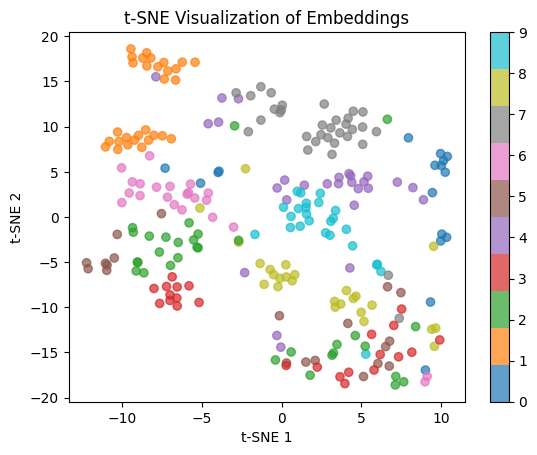

In [34]:
from sklearn.manifold import TSNE

reduced = TSNE(n_components=2, random_state=42).fit_transform(feats)
plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap="tab10", alpha=0.7)
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar()
plt.show()

## ArcFace

The ArcFace loss introduces an **additive angular margin** \( m \) to the angle \( \theta \) between feature and class weight vectors.

### **Formula:**

$$
\mathcal{L} = -\frac{1}{N} \sum_{i=1}^{N} \log \frac{e^{s \cdot \cos(\theta_{y_i} + m)}}{e^{s \cdot \cos(\theta_{y_i} + m)} + \sum_{j \ne y_i} e^{s \cdot \cos(\theta_j)}}
$$

Where:
- \( \cos(\theta_j) \) is the cosine similarity
- \( m \) is the angular margin (e.g., 0.5)
- \( s \) is a scaling factor (e.g., 30)
- \( N \) is the batch size
- \( y_i \) is the ground-truth class

ArcFace improves inter-class separability and intra-class compactness in angular space.

---


In [68]:
class ArcFaceLoss(nn.Module):
    def __init__(self, in_features, out_features, margin=0.5, scale=30.0):
        super(ArcFaceLoss, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
        self.margin = margin
        self.scale = scale
        self.cos_m = math.cos(margin)
        self.sin_m = math.sin(margin)
        self.th = math.cos(math.pi - margin)
        self.mm = math.sin(math.pi - margin) * margin

    def forward(self, input, labels):
        input_norm = F.normalize(input, dim=1)
        weight_norm = F.normalize(self.weight, dim=1)
        cosine = F.linear(input_norm, weight_norm)
        sine = torch.sqrt(1.0 - torch.clamp(cosine**2, 0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m  # cos(θ + m)

        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1, 1), 1.0)

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.scale
        return output


In [69]:
model = SimpleCNN(embedding_dim=2).to(device)
criterion = ArcFaceLoss(in_features=2, out_features=10, margin=0.5, scale=30.0).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

all_feats = []
all_labels = []

for epoch in range(20):
    model.train()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        embeddings = model(images)
        logits = criterion(embeddings, labels)
        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")
    scheduler.step()

    if epoch in [0, 4, 9, 19]:
        model.eval()
        with torch.no_grad():
            sample_imgs, sample_labels = next(iter(trainloader))
            sample_feats = model(sample_imgs.to(device)).cpu()
            all_feats.append(sample_feats)
            all_labels.append(sample_labels)


Epoch 1, Loss: nan
Epoch 2, Loss: nan
Epoch 3, Loss: nan
Epoch 4, Loss: nan
Epoch 5, Loss: nan
Epoch 6, Loss: nan
Epoch 7, Loss: nan
Epoch 8, Loss: nan
Epoch 9, Loss: nan
Epoch 10, Loss: nan
Epoch 11, Loss: nan
Epoch 12, Loss: nan
Epoch 13, Loss: nan
Epoch 14, Loss: nan
Epoch 15, Loss: nan
Epoch 16, Loss: nan
Epoch 17, Loss: nan
Epoch 18, Loss: nan
Epoch 19, Loss: nan
Epoch 20, Loss: nan


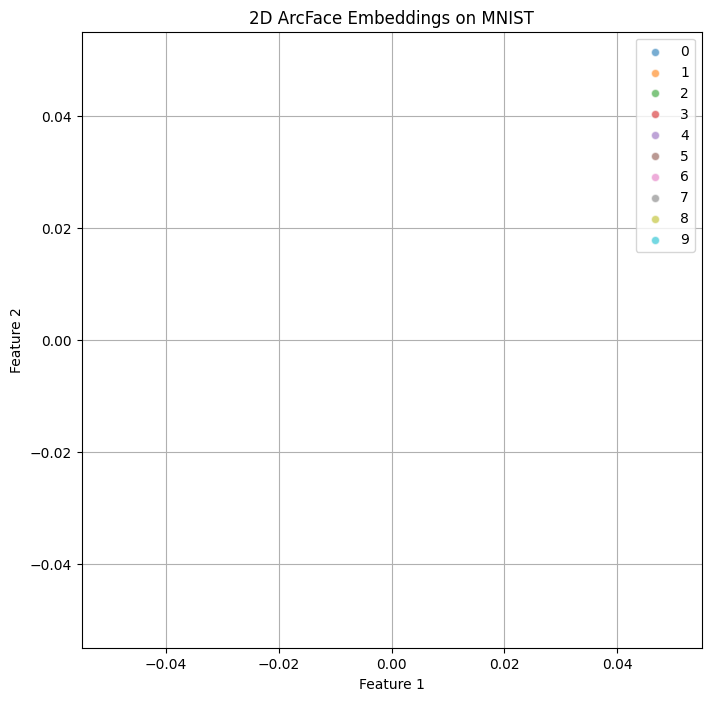

In [70]:
feats = torch.cat(all_feats, dim=0)
labels = torch.cat(all_labels, dim=0)

plt.figure(figsize=(8, 8))
for i in range(10):
    idx = labels == i
    plt.scatter(feats[idx, 0], feats[idx, 1], label=str(i), alpha=0.6, edgecolors='w')

plt.title("2D ArcFace Embeddings on MNIST")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()


## Histogram Loss

Histogram Loss is a deep metric learning loss function designed to minimize the probability that **a randomly chosen negative pair is more similar than a randomly chosen positive pair**.

### **Formula (Conceptual)**

The loss minimizes:

$$
\mathcal{L} = \sum_{t=1}^{T} h^{-}(t) \cdot \left( \sum_{k=t}^{T} h^{+}(k) \right)
$$

Where:
- \( h^+(t) \): histogram bin for positive pair similarity at bin \( t \)
- \( h^-(t) \): histogram bin for negative pair similarity at bin \( t \)
- \( T \): number of bins

### 🔍 Goal

Encourages all positive pairs to have higher similarity scores than negative pairs by minimizing their overlap in the similarity histogram.

---

### 🔧 Pros
- Does not require margin tuning like contrastive/triplet loss
- Uses **all positive and negative pairs** within a batch
- Differentiable histogram approximation

In [25]:
class HistogramLoss(nn.Module):
    def __init__(self, num_bins=100):
        super(HistogramLoss, self).__init__()
        self.num_bins = num_bins
        self.eps = 1e-7
        self.delta = 2.0 / (num_bins - 1)
        self.bins = torch.linspace(-1.0, 1.0, steps=num_bins)

    def forward(self, embeddings, labels):
        device = embeddings.device
        self.bins = self.bins.to(device)
        sim_matrix = F.cosine_similarity(embeddings.unsqueeze(1), embeddings.unsqueeze(0), dim=2)
        label_matrix = labels.unsqueeze(1) == labels.unsqueeze(0)

        pos_mask = label_matrix & ~torch.eye(labels.size(0), device=device).bool()
        neg_mask = ~label_matrix

        pos_sims = sim_matrix[pos_mask]
        neg_sims = sim_matrix[neg_mask]

        pos_hist = self._compute_histogram(pos_sims)
        neg_hist = self._compute_histogram(neg_sims)

        loss = torch.sum(neg_hist * torch.cumsum(pos_hist, dim=0))
        return loss

    def _compute_histogram(self, sims):
        sims = sims.clamp(-1, 1)
        device = sims.device
        bins = self.bins.to(device)
        bin_width = self.delta

        # For each similarity, calculate soft assignments to bins using triangular kernel
        # hist[b] = sum over sims of max(0, 1 - |sim - bin_center|/bin_width)
        diff = torch.abs(sims.unsqueeze(1) - bins.unsqueeze(0)) / bin_width
        weights = torch.clamp(1 - diff, min=0)  # triangular kernel weights

        hist = weights.sum(dim=0)
        hist /= (sims.size(0) + self.eps)  # normalize histogram

        return hist



In [24]:
class SimpleCNN(nn.Module):
    def __init__(self, embedding_dim=2):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3), nn.ReLU(), nn.AdaptiveAvgPool2d(1)
        )
        self.embedding = nn.Linear(64, embedding_dim)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.embedding(x)


In [27]:
model = SimpleCNN(128).to(device)
criterion = HistogramLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(10):
    model.train()
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        embeddings = model(x)
        loss = criterion(embeddings, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 0.0898
Epoch 2, Loss: 0.0702
Epoch 3, Loss: 0.0480
Epoch 4, Loss: 0.0259
Epoch 5, Loss: 0.0288
Epoch 6, Loss: 0.0365
Epoch 7, Loss: 0.0261
Epoch 8, Loss: 0.0130
Epoch 9, Loss: 0.0160
Epoch 10, Loss: 0.0076


https://github.com/deepinsight/insightface.git


In [28]:
from sklearn.manifold import TSNE

reduced = TSNE(n_components=2, random_state=42).fit_transform(embeddings)
plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap="tab10", alpha=0.7)
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar()
plt.show()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.